In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave, struct, math, random
from sklearn.linear_model import LinearRegression
from scipy import signal
from scipy import stats
from nptdms import TdmsFile

import scipy

from scipy.signal import find_peaks, peak_prominences
from collections import Counter
import os
import json
import time
import re
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import fnmatch
import os
from glob import glob
# first part with least squares
from scipy.optimize import curve_fit
 
# second part about ODR
from scipy.odr import ODR, Model, Data, RealData
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#!pip install plotly==5.11.0
import plotly.express as px
import plotly.graph_objects as go



In [120]:
def SortLegacyFiles(dataFiles):
    ind=np.argsort([int(x.split('_')[-1].split('.')[0])  for x in dataFiles])
    nFiles=[]
    isSepi=True
    for i in ind:
        nFiles.append( dataFiles[i])
    dataFiles=nFiles
    return dataFiles


def IVorCV(loadFastMonitor):
        IT=0
        IV=0
        for x in loadFastMonitor:
            c=x['current']
            if (np.max(c)>0.02 and np.min(c)<0):
                IV+=1
            else:
                IT+=1

        if IT/(IT+IV)>.6:
            isIT=True
        else:
            isIT=False
            
        print( IT/(IT+IV))
        
        return isIT
 
def LoadCurves(dataFiles):
    FastMonitor=[]
    isLegacy=False
    t0=0
    minTime=10000000000
    _isLegacy=isLegacy
    _minTime=minTime
    cc=0
    for file in dataFiles:
        cc=cc+1
        fileID=os.path.basename(file).split('_')
        if len(fileID[0])==10:
            fileID = fileID[1] + "".join(fileID[2:]) + '_' +os.path.basename(file)
        elif np.core.defchararray.isnumeric(fileID[0] )==True:
            fileID=  fileID[0] + "".join(fileID[2:]) + '_' +os.path.basename(file)
        else:
            fileID=os.path.basename(file)
        
        found=False
        try:
            _isLegacy, _minTime,fm=LoadCurve(file)
            found=True
        except:
            try:
                time.sleep(3)
                _isLegacy, _minTime,fm=LoadCurve(file)
                found=True
            except:
                time.sleep(2)
        
        if found and len(fm["time"])>10:
            
            isLegacy=isLegacy or _isLegacy
            if _minTime<minTime:
                minTime=_minTime
                
            if (isLegacy):
                times=fm['time']
                times=times+t0
                t0=np.max(times)
                fm['time']=times
                
            fm['file']=fileID
            FastMonitor.append(fm)
                
    fixed=[]
 
    return FastMonitor    

    
def LoadCurve(file):
    timeC1=[]
    tdms_file = TdmsFile.read(file)
    minTime=10000000000
    isLegacy=False
    for group in tdms_file.groups():
        group_name = group.name
        bias=[]
        for channel in group.channels():
            channel_name = channel.name
            if (channel_name=="Time"):
                timeC1=np.array(channel)
                if timeC1[0]<minTime:
                    minTime=timeC1[0]
            elif channel_name=="Bias":
                bias=np.array(channel)
            else:    
                currentIV=np.array(channel)
        if len(timeC1)==0:
            try:
                timeC1=channel.time_track(True)
            except:
                timeC1=np.linspace(0,len(currentIV)/70000.0,len(currentIV))
                minTime=0
                isLegacy=True
    return isLegacy, minTime, { "time":timeC1,"realTime":timeC1[0],"current":currentIV,"bias":bias, 'isLegacy':isLegacy }


def loadMonitors(monitorFiles):
    dts=[]
    
    CVMonitor=[]
    for monitor in monitorFiles:
        tdms_file = TdmsFile.read(monitor)
        timeC=[]
        current=[]
        for group in tdms_file.groups():
            group_name = group.name
            for channel in group.channels():
                channel_name = channel.name
                if (channel_name=="Time"):
                    timeC=np.array(channel) 
                elif channel_name=="Bias":
                    bias=channel
                else:    
                    current=np.array(channel) 
        try:
            if tdms_file    .properties['author']:
                t=current
                current=timeC
                timeC=t
        except:
            pass
        if len(timeC)>110:
            CVMonitor.append({ "time":timeC[2:] ,"current":current[2:] })    
    return CVMonitor

def BatchAll(fast,conductances,times):
            t=fast['time']
            c=fast['current']
            b=fast['bias']
            
            pos=np.where(np.diff(b)>0)
            neg = np.where(np.diff(b)<0)
            
            cutthresh=.08
            
            cPos = c[neg]
            tPos = t[neg]
            bPos = b[neg]
            cPos = ((cPos-np.mean(cPos))/bPos)[np.abs(bPos)>cutthresh]
            tPos = tPos[np.abs(bPos)>cutthresh]
            bPos=bPos[np.abs(bPos)>cutthresh]
            
            
            cNeg = c[neg]
            tNeg = t[neg]
            bNeg = b[neg]
            cNeg = ((cNeg-np.mean(cNeg))/bNeg)[np.abs(bNeg)>cutthresh]
            tNeg = tNeg[np.abs(bNeg)>cutthresh]
            bNeg=bNeg[np.abs(bNeg)>cutthresh]
            
            
            if len(t)>0:
                conductances=np.concatenate([conductances,cNeg,cPos]) 
                times=np.concatenate([times,tNeg,tPos])
            return conductances,times
                   
def BatchMids(fast,conductances,times):    
            t=fast['time']
            c=fast['current']
            b=fast['bias']

            diffs=np.abs(np.diff(np.diff(b)))
            diffs=np.concatenate([[0],np.where( diffs>(np.max(diffs)/2))[0],[len(b)]])

            tt=[]
            cc=[]
            for i in range(1, len(diffs)):
                sB=b[diffs[i-1]:diffs[i]]
                sT=t[diffs[i-1]:diffs[i]]
                sC=c[diffs[i-1]:diffs[i]]

                m=int(len(sB)/2)
                tt.append( sT[m])
                p=np.polyfit(sB,sC,1)
                cc.append(p[0])

            if len(t)>0:
                conductances=np.concatenate([conductances,cc]) 
                times=np.concatenate([times,tt])
            return conductances,times
        

def BatchKeys(fast,conductances,times):    
            t=fast['time']
            c=fast['current']
            b=fast['bias']

            diffs=np.abs(np.diff(np.diff(b)))
            diffs=np.concatenate([[0],np.where( diffs>(np.max(diffs)/2))[0],[len(b)]])

            tt=[]
            cc=[]
            for i in range(1, len(diffs)):
                sB=b[diffs[i-1]:diffs[i]]
                sT=t[diffs[i-1]:diffs[i]]
                sC=c[diffs[i-1]:diffs[i]]
                sC=sC-np.mean(sC[np.abs(sB)<.05])

                tt.append( sT[0])
                cc.append(sC[0]/sB[0])
                
                m=int(len(sB)/4.0)
                tt.append( sT[m])
                cc.append(sC[m]/sB[m])

                m=int(len(sB)/2.0)
                tt.append( sT[m])
                p=np.polyfit(sB,sC,1)
                cc.append(p[0])

                m=int(3.0*len(sB)/4)
                tt.append( sT[m])
                cc.append(sC[m]/sB[m])
                
                tt.append( sT[-1])
                cc.append(sC[-1]/sB[-1])
            if len(t)>0:
                conductances=np.concatenate([conductances,cc]) 
                times=np.concatenate([times,tt])
            return conductances,times
        
def BatchMonitors(monitors,fasts,isIT,allPoints):
    batches=[]
    for monitor in monitors:
        montimes=monitor['time'] 
        mTime=np.min(montimes)
        MTime=np.max(montimes)
        monCond =monitor['current']/-.2
        monitorFasts =[x for x in fasts if x['time'][0]>mTime and x['time'][0]<MTime]
        
        times=np.array(montimes )
        conductances=np.array(monCond )
        for fast in monitorFasts:
            if isIT:
                t=fast['time']
                c=fast['current']
                conductances=np.concatenate([conductances,c/-.2]) 
                times=np.concatenate([times,t])
            elif allPoints=='All':
                conductances,times=BatchAll(fast,conductances,times) 
            elif allPoints=='Keys':
                conductances,times=BatchKeys(fast,conductances,times)
            elif allPoints=='Mids':
                conductances,times=BatchMids(fast,conductances,times)
        ind=np.argsort(times)
        times=times[ind]
        conductances=conductances[ind]
       
        
         
        if len(times)>4:
            
            minTime = np.min(times)
            maxTime = np.max(times)
            if allPoints =='All':
                newTimes = np.linspace(minTime,maxTime,  int((maxTime-minTime)/1.00040436e-03))
            else:
                newTimes = np.linspace(minTime,maxTime,  int((maxTime-minTime)/.1))
            if len(newTimes)>3:
                batches.append({'times':newTimes, 'conductances':np.interp(newTimes,times, conductances ) })
         
         
    minTime = np.min([x['times'][0] for x in batches])
    for i  in range(len( batches)):
        fm=batches[i]
        fm['times']=fm['times']-minTime
        batches[i]=fm
   
    print('Fishing Attempts:',len(batches))    
    return batches

def GetDriftTimes(batches):
    driftTimes=[]
    plt.figure(figsize=(15,5))
    plt.title('Raw Traces')
    for b in batches:
        times=np.array(b['times']) 
        cond=np.array(b['conductances']) 
        ind=np.argsort(times)
        times=times[ind]
        cond=cond[ind]

        ind=np.argmax(cond)
        times=times[:ind]
        cond=cond[:ind]
        if len(times)>1:
            driftTimes.append(times[-1]-times[0])
        plt.semilogy(times,cond)
    plt.ylabel('Conductance (nS)')
    plt.xlabel('Times(s)')
    plt.show()

    plt.title('Drift Times')
    plt.hist(driftTimes)    
    plt.show()    
    return driftTimes

def DetermineErrors(batches, sName, errorCut):
        plt.figure(figsize=(8,5))
        errors=[]
        nBatch=0
        cc=0
        newBatches=[]
        for b in batches:
            cc+=1
            ind=np.argmax(b['conductances'])+1
            ts=np.array(b['times'][:ind])
            cs=np.log10(np.array(b['conductances'][:ind]))
            
            if len(cs)>2:
                    ts2=ts[cs>-.2]
                    cs2=cs[cs>-.2]
                    if len(ts2)>2:
                        p=np.polyfit(ts2,cs2,1)
                        dist=np.abs( p[0]*ts2-cs2+p[1])/np.sqrt(p[0]**2+1)
                        error=np.mean(dist)
                        errors.append(error)

                        b['bSlope']=p[0]
                        b['error']=error
                        b['ups']=cs
                        newBatches.append(b)
                        nBatch+=1  
                    
        errors=np.array(errors)
        plt.plot([errorCut,errorCut],[0,20],'r')
        rate = len(errors[errors>errorCut])/(len(errors)+.01)
        plt.title('Errors ' +sName + ' Cut:%.1f%%'%(100-rate*100) )
        plt.hist(errors) 
        plt.xlabel('MSE Log$_{10}$(nS)')
        plt.ylabel('Count')
        plt.show()     
        
        plt.figure(figsize=(15,5))
        alls=[]
        kept=0
        numberBatch=0
        for b in newBatches:
            numberBatch+=1
            if ('error' in b) and (b['error']>errorCut):
                kept+=1
                plt.semilogy(b['times'],(b['conductances']))
                alls.extend( b['ups'])
        alls=np.array(alls)
        plt.title('Filtered')
        plt.xlabel('Time (s)')
        plt.ylabel('Conductance (nS)')
        plt.show()
        return newBatches,alls,errors 
    
def PlotFiltered(alls,allPoints):
        v,bins=np.histogram(alls[alls>-1],bins=100)
        plt.semilogx(10**bins[1:],v)
        plt.xlabel('Filtered Conductance  (nS)')
        plt.ylabel('Count')
        plt.show()

        plt.hist(10**alls,bins=250) 
        plt.xlabel('Filtered Conductance (nS)')
        plt.ylabel('Count')
        if len(alls)>0 and np.max(10**alls)>20:
               plt.xlim([0,20])
        plt.show()        
        
       
        aVs=[]
        cc=0
        for b in batches:
            if ('error' in b) and (b['error']>errorCut):
                v,_=np.histogram(np.log10(b['conductances']),bins=bins)
                v=v/( len(b['conductances'])**.5 )
                if len(aVs)==0:
                    aVs=v
                else:
                    aVs+=v 
                cc+=1

        plt.semilogx(10**bins[:-1],aVs)
        plt.xlabel('Normed Filtered Conductance  (nS)')
        plt.ylabel('Norm Count')
        plt.show()
        return bins,aVs    
    
def BatchLegacyFiles(fasts,isIT,allPoints):
    batches=[]
    times = [f['time'][0] for f in fasts]
    timeLength =np.mean([(f['time'][-1]-f['time'][0]) for f in fasts])
    diff=np.concatenate([ [0] , np.argwhere( np.diff(times)>timeLength*1.5).ravel(), [len(times)]])
    
    for i in range(0,len(diff)-1):
        times=np.array([] )
        conductances=np.array([] )
        for j in range(diff[i]+1,diff[i+1]):
            fast=fasts[j]
            if isIT:
                t=fast['time']
                c=fast['current']
                conductances=np.concatenate([conductances,c/-.2]) 
                times=np.concatenate([times,t])
            elif allPoints=='All':
                conductances,times=BatchAll(fast,conductances,times) 
            elif allPoints=='Keys':
                conductances,times=BatchKeys(fast,conductances,times)
            elif allPoints=='Mids':
                conductances,times=BatchMids(fast,conductances,times)
        ind = np.where(np.diff(times)<0) [0]
       
        if len(ind)>0:
            times=times[:int(ind)]
            conductances=conductances[:int(ind)]
        ind=np.argsort(times)
        times=times[ind]
        conductances=conductances[ind]
       
        times=times[conductances>(.15)]
        conductances=conductances[conductances>(.15)]
         
        if len(times)>4:
            
            minTime = np.min(times)
            maxTime = np.max(times)
            if allPoints =='All':
                newTimes = np.linspace(minTime,maxTime,  int((maxTime-minTime)/1.00040436e-03))
            else:
                newTimes = np.linspace(minTime,maxTime,  int((maxTime-minTime)/.1))
            
            batches.append({'times':newTimes, 'conductances':np.interp(newTimes,times, conductances ) })
         
         
    minTime = np.min([x['times'][0] for x in batches])
    for i  in range(len( batches)):
        fm=batches[i]
        fm['times']=fm['times']-minTime
        batches[i]=fm
   
    print('Fishing Attempts:',len(batches))    
    return batches    

from array import array
def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    distance=[]
    times=[]
    data = array('B')
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n':
            d=file1.readline().decode('ascii')
            dd=d.strip().split(' ')
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
            if  d.startswith('chunk'):
                parts = d.split('\t')
                dist=float(parts[5])
                time=float(parts[3])
                chunks.append({'points':int(parts[1]),'distperpoint':dist, 'timeperpoint':time})

        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )
        i=0
        cDist=0
        for chunk in chunks:
            chunkDist=[]
            chunkCurrent=[]
            for j in range(0,chunk['points']):
                f=(struct.unpack('<f', data[i:i+4]))
                chunkCurrent.append(f)
                cDist+=chunk['distperpoint']
                chunkDist.append(cDist)
                i+=4
                
           
            distance.append(np.array(chunkDist)*1e9)
            current.append(np.array(chunkCurrent).ravel())
            times.append(  np.linspace(0, len(chunkDist)*chunk['timeperpoint'], len(chunkDist)))
    return distance,current,bias,times

In [135]:
folders = [
            ['eDNA-.2VFishing',r'\\BIOD1633\Data\PEG4-Biotin\20230208_SubPeg4-Biotin_SA_TipBiotincyst\CBBreak',-1 ], 
          ]

alls=[]
filteredAll=[]
averagePoints=[]
#plotDictionary={}
t0=0
allPoints='All'
errorCut=.1
for dirs in folders:
        sDir =dirs[1]
        sName =dirs[0]
        timeThresh=dirs[2]
        dataFiles = glob( sDir+"\\*.tdms", recursive=False)
        dataFiles=[x for x in dataFiles if '_index' not in x.lower()]

        monitorFiles=sorted([x for x in dataFiles if 'monitor'  in x.lower()])
        dataFiles = [x for x in dataFiles if 'monitor' not in x.lower()]
        dataFiles=sorted(dataFiles,key=lambda x: ("000" + os.path.basename(x).split("_")[1])[-4:])

        if len(dataFiles)==0:
            continue
        isLegacy=False
        if np.core.defchararray.isnumeric(os.path.basename(dataFiles[0]).split('_')[0])==False or isLegacy:
            print('File legacy')
            print(len(dataFiles))
            dataFiles=SortLegacyFiles(dataFiles)
            isLegacy=True
        
       
        loadFastMonitor=0
        fasts= LoadCurves(dataFiles  )
        
        isIT=True
        monitors=loadMonitors(monitorFiles)
        batches=BatchMonitors(monitors,fasts,isIT,allPoints)

Fishing Attempts: 37


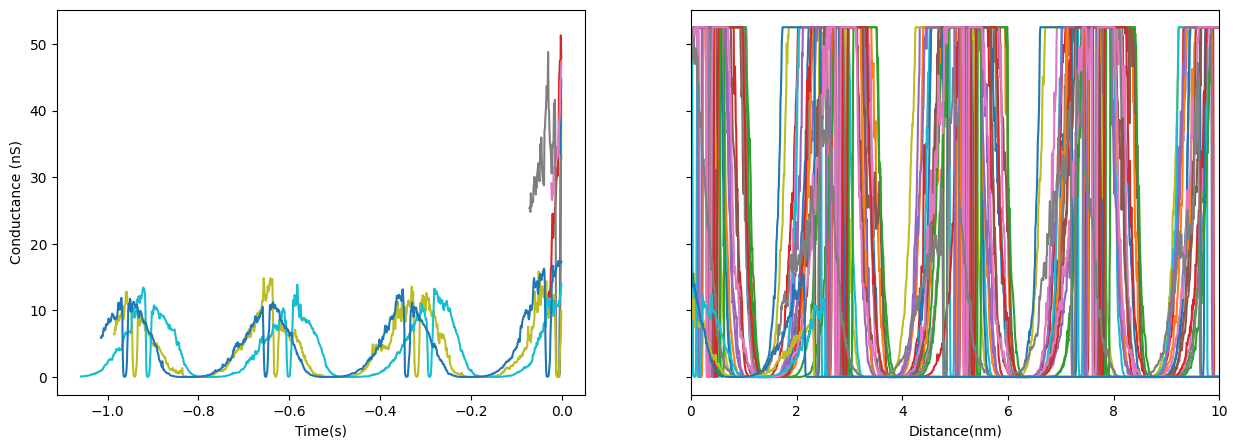

In [136]:
cc=0
v=7.838378887532021
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5),sharey=True)
for b in batches:
    t=b['times']
    cond=b['conductances']
    ind=np.argmax(cond)
    t=t-t[ind]
    
    ax1.plot(t[t<0],cond[t<0])
    ax2.plot(t[t>0]*v,cond[t>0])
    cc+=1
    ax1.set_xlabel('Time(s)')
    ax2.set_xlabel('Distance(nm)')
   # ax1.set_ylim([.004,100])
    ax2.set_xlim([0,10])
    ax1.set_ylabel('Conductance (nS)')
    #plt.show()    
    if cc>20:
        break
     
     


In [137]:
fasts[0]

{'time': array([3.75875947e+09, 3.75875947e+09, 3.75875947e+09, ...,
        3.75875947e+09, 3.75875947e+09, 3.75875947e+09]),
 'realTime': 3758759466.2766848,
 'current': array([-10.50150385, -10.50150385, -10.50150385, ..., -10.50150385,
        -10.50150385, -10.50150385]),
 'bias': array([-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2]),
 'isLegacy': False,
 'file': '1break.tdms_3758759471_1_break.tdms'}

In [121]:
distance,current,bias,times=loadMI(r'\\BIOD1633\Data\30bp DNA\2023_02_06_30bpDNA_PBS_1uMDNA_added\.2V\Fish\dsDNA_230206_181111.mi')

11.111111043583655 0.009999999776482582 1111.1111291936345
10.555555491404473 10.0 1.0555555491404474
5.333333305854483 33.0 0.1616161607834692
13.527808956459758 1.7258426966292135 7.838378887532021


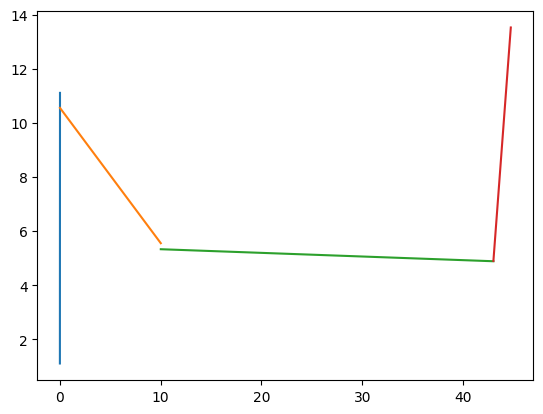

In [126]:
t0=0
for i in range(len(times)):
    t=times[i]+t0
    plt.plot(t ,distance[i])
    print(np.max(distance[i]),np.max(times[i]),np.max(distance[i])/np.max(times[i]))
    t0=np.max(t)
    
